In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_swiss_roll

In [2]:
print(make_swiss_roll.__doc__)

Generate a swiss roll dataset.

    Read more in the :ref:`User Guide <sample_generators>`.

    Parameters
    ----------
    n_samples : int, default=100
        The number of sample points on the Swiss Roll.

    noise : float, default=0.0
        The standard deviation of the gaussian noise.

    random_state : int, RandomState instance or None, default=None
        Determines random number generation for dataset creation. Pass an int
        for reproducible output across multiple function calls.
        See :term:`Glossary <random_state>`.

    hole : bool, default=False
        If True generates the swiss roll with hole dataset.

    Returns
    -------
    X : ndarray of shape (n_samples, 3)
        The points.

    t : ndarray of shape (n_samples,)
        The univariate position of the sample according to the main dimension
        of the points in the manifold.

    Notes
    -----
    The algorithm is from Marsland [1].

    References
    ----------
    .. [1] S. Marsland,

# Creating the data

In [3]:
def sample_batch(batch_size):
    data, t = make_swiss_roll(n_samples=batch_size)
    data = data[:, [2, 0]] / 10 # scale data and using only 2 dimensions (z and x)
    data = data * np.array([1, -1]) # flip x axis
    return torch.from_numpy(data)

In [4]:
x0 = sample_batch(3_000)

# Implementation of a simple forward process

In the forward process noise is gradually added to the data over time by:

$q(x_t|x_{t-1}) = \mathcal{N}(x_t; \sqrt{1-\beta_t}x_{t-1}, \beta_t\mathbf{I})$

Where:
- $q(x_t|x_{t-1})$ represents the conditional probability of $x_t$ given $x_{t-1}$.
- $\mathcal{N}$ is used to denote a normal (Gaussian) distribution.
- $x_t$ is the variable at time step $t$.
- $\sqrt{1-\beta_t}x_{t-1}$ is the mean of the Gaussian distribution.
- $\beta_t\mathbf{I}$ is the covariance matrix, where $\mathbf{I}$ represents the identity matrix.
- $\beta_t$ is the noise schedule at time t.

In [5]:
import torch

def forward_process(data, T, betas):

    for t in range(T):
        beta_t = betas[t]
        mu = data * torch.sqrt(1 - beta_t)
        std = torch.sqrt(beta_t)

        # Sample from q(x_t | x_{t-1})
        data = mu + torch.randn_like(data) * std # sample from normal distribution with mean mu and std std (Reparametrization trick)

    return data



### Applying the forward process

In [6]:
T = 40
betas = torch.sigmoid(torch.linspace(-18, 10, T)) * (3e-1 - 1e-5) + 1e-5
xT = forward_process(x0, T, betas)

Here we check the mean and std of the samples.
The mean should be close to 0 and the std close to 1 since we are sampling from a normal distribution ~ N(0, 1)

In [7]:
print(xT.mean(0))
print(xT.std(0))

tensor([ 0.0076, -0.0040], dtype=torch.float64)
tensor([0.9983, 1.0011], dtype=torch.float64)


# MLP to predict $\Mu$ and $\Sigma$

In [24]:
class MLP(nn.Module):
    def __init__(self, N=40, data_dim=2, hidden_dim=64):
        super().__init__()

        self.network_head = nn.Sequential(nn.Linear(data_dim, hidden_dim),
                                          nn.ReLU(), 
                                          nn.Linear(hidden_dim, hidden_dim), 
                                          nn.ReLU(),)
        
        self.network_tail = nn.ModuleList([nn.Sequential(nn.Linear(hidden_dim, hidden_dim),
                                          nn.ReLU(), 
                                          nn.Linear(hidden_dim, data_dim * 2),) for t in range(N)])
        
    def forward(self, x, t):

        h = self.network_head(x)
        tmp = self.network_tail[t](h)
        mu, h = torch.chunk(tmp, 2, dim=1)
        var = torch.exp(h)
        std = torch.sqrt(var)

        return mu, std

## Improving the forward process

In [33]:
class Diffusion():

    def __init__(self, T, model: nn.Module, dim=2):
        self.T = T
        self.model = model
        self.dim = dim
        self.betas = torch.sigmoid(torch.linspace(-18, 10, T)) * (3e-1 - 1e-5) + 1e-5
        # self.betas = torch.linspace(1e-04, 1e-02, T)
        self.alphas = 1 - self.betas
        self.alphas_cumprod = torch.cumprod(self.alphas, 0)

    def forward(self, x0, t):

        assert t > 0 and t <= self.T, "t must be in the range [1, T]"

        t = t-1

        mu = torch.sqrt(self.alphas_cumprod[t]) * x0
        epsilon = torch.randn_like(x0)
        std = torch.sqrt(1 - self.alphas_cumprod[t])
        
        return mu + std * epsilon
    
    def reverse(self, xt, t):
                
        assert t > 0 and t <= self.T, "t must be in the range [1, T]"
    
        t = t-1

        mu, std = self.model(xt, t) # the model outputs mu and std for the distribution. The model is trained to predict mu and std for each time step
        epsilon = torch.randn_like(xt)
        
        return mu + std * epsilon
    
    def sample(self, batch_size):
    
        noise = torch.randn((batch_size, self.dim))
        x = noise
        
        samples = [x]
        for t in range(self.T, 0, -1):
            
            if not (t == 1):
                x = self.reverse(x, t)
            
            samples.append(x)
            
        return samples[::-1]

# Visualization methods

In [30]:
import imageio.v2 as imageio

def visualize_xt(data):
    
    ''' Visualizes the data in a specific time step. '''

    plt.scatter(data[:, 0].data.numpy(), data[:,1].data.numpy(), alpha=0.1)
    plt.xlim(-2, 2)
    plt.ylim(-2, 2)
    plt.xticks([-2, 0, 2])
    plt.yticks([-2, 0, 2])
    plt.title(r'$q(x^{(t)})$')
    


def visualize_diffusion_process(diffusion_model, x0, output_path, steps=50, xlim=(-2, 2), ylim=(-2, 2), alpha=0.1):
    
    ''' This method generates a GIF that shows the diffusion process over time.
    It also saves an image for each time step in the ./samples folder.'''

    images = []
    for t in range(1, steps + 1):
        xT = diffusion_model.forward(x0, t)
        
        plt.figure()
        plt.scatter(xT[:, 0].numpy(), xT[:, 1].numpy(), alpha=alpha)
        plt.xlim(xlim)
        plt.ylim(ylim)
        plt.title(f"Time step: {t}")

        # Save the plot as an image
        image_path = f"./samples/frame_{t}.png"
        plt.savefig(image_path)
        images.append(imageio.imread(image_path))
        plt.close()

    # Generate the GIF
    imageio.mimsave(output_path, images, duration=0.2)

def visualize_comparison(model, data, t, T):
    fontsize = 14
    fig = plt.figure(figsize=(10, 3))
    x0 = [data, model.forward(data, t), model.forward(data, T)]

    for i in range(3):
        plt.subplot(1, 3, i+1)
        plt.scatter(x0[i][:, 0].data.numpy(), x0[i][:,1].data.numpy(), alpha=0.1)
        plt.xlim(-2, 2)
        plt.ylim(-2, 2)
        plt.xticks([-2, 0, 2])
        plt.yticks([-2, 0, 2])
        plt.gca().set_aspect('equal', adjustable='box')
        plt.title(f"$t$ = {t if i == 1 else T if i == 2 else 0}")
        if i == 0:
            plt.ylabel(r'$q(x^{(0..T)})$')




# Example Usage

In [40]:
x0 = sample_batch(3_000)
# mlp_model = torch.load('model_paper1')
mlp_model = MLP()
model = Diffusion(40, mlp_model)
xT = model.forward(x0, 20)

## Reverse Process Sampling

In [35]:
samples = model.sample(1000)

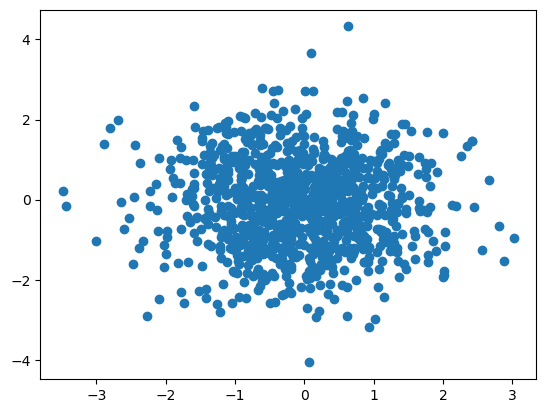

In [46]:
t = 12
plt.scatter(samples[t][:, 0].data.numpy(), samples[t][:, 1].data.numpy())

### Visualizing a specific time step

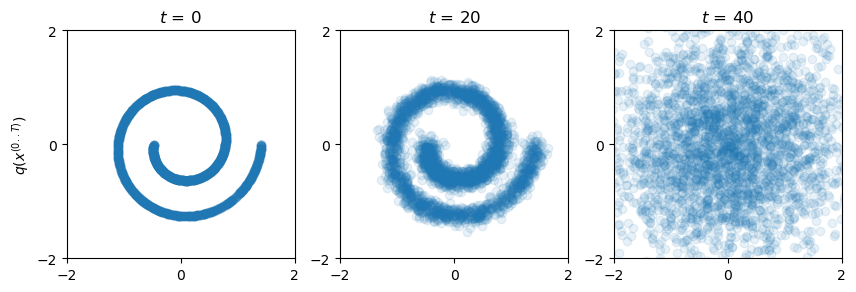

In [45]:
visualize_comparison(model, x0, 20, 40)

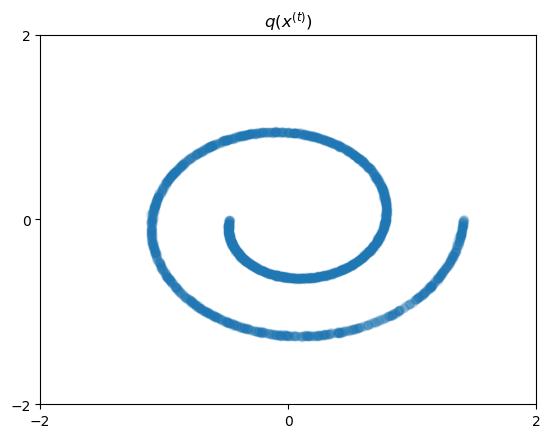

In [43]:
t = 2
xt = model.forward(x0, t)
visualize_xt(xt)